In [152]:
# data and data loading
import pyreadr
import pandas as pd

# sklearn modeling and processing capabilities
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# visualizations
from itables import show
from plotnine import (
    ggplot, aes, xlab, ylab, ggtitle, geom_point, theme, facet_wrap, geom_line, geom_boxplot
)

from utils import *

### Loading the data

In [ ]:
# loading the data
fuel_economy = pyreadr.read_r("data/FuelEconomy.RData") # also works for Rds

# done! let's see what we got
# result is a dictionary where keys are the name of objects and the values python
# object
# fuel_economy.items()
# print(fuel_economy.keys()) # let's check what objects we got
fuel_economy_df = pd.concat([df.assign(year=int(key[4:]))for key, df in fuel_economy.items()])
fuel_economy_df.columns = (fuel_economy_df.columns
 .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
 .str.lower()
)
show(fuel_economy_df)
# df1 = result["df1"] # extract the pandas data frame for object df1

### Visualize the data by engine displacement

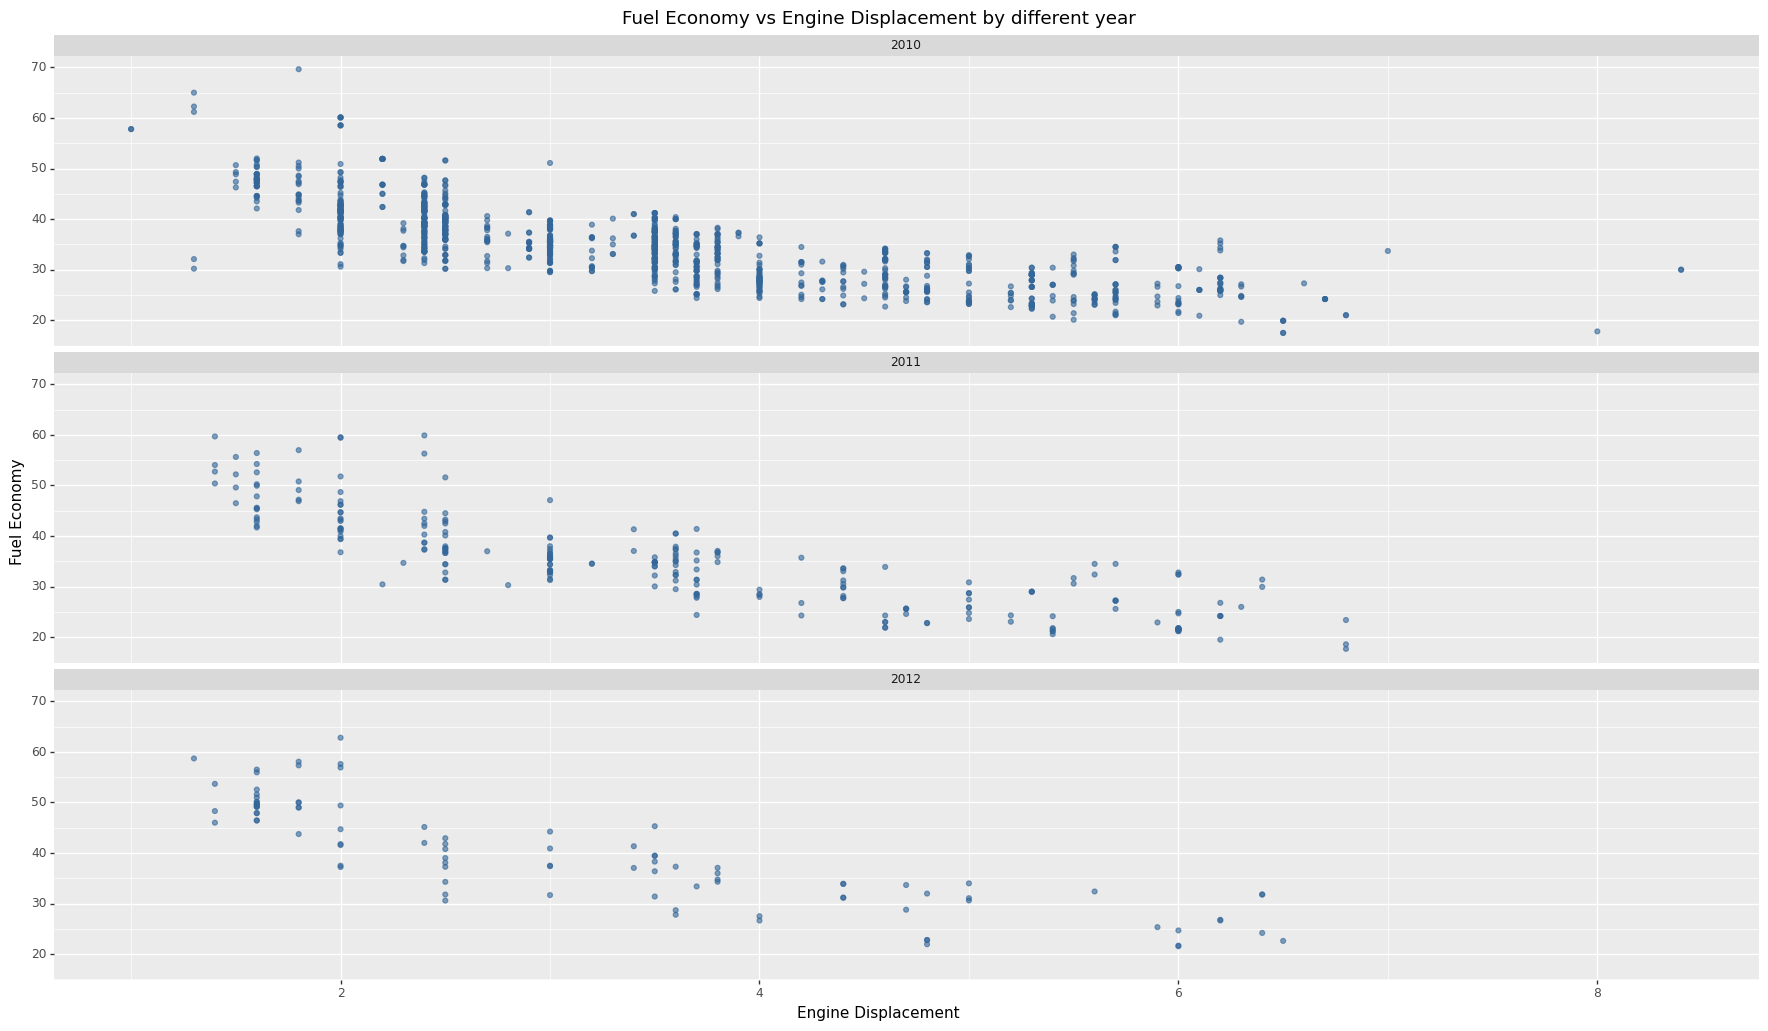

<ggplot: (8788687960080)>

In [92]:
(ggplot(fuel_economy_df) +
    aes(x="eng_displ", y="fe") +
    geom_point(alpha=0.6, color="#336699") +
    facet_wrap("year", ncol=1) +
    theme(figure_size=(22, 12)) +
    xlab("Engine Displacement") +
    ylab("Fuel Economy") +
    ggtitle("Fuel Economy vs Engine Displacement by different year")
)

### Data splitting

In [40]:
TARGET = "fe"
# for example purposes, only engine displacement
PREDICTORS = ["eng_displ"]

is_train = fuel_economy_df["year"] == 2010
is_test = fuel_economy_df["year"] == 2011

# split into train and test
# train set
X_train = fuel_economy_df[is_train][PREDICTORS]
y_train = fuel_economy_df[is_train][TARGET]

# test set
X_test = fuel_economy_df[~is_train][PREDICTORS]
y_test = fuel_economy_df[~is_train][TARGET]

print("Train set size is", X_train.shape[0])
print("test set size is", X_test.shape[0])

Train set size is 1107
test set size is 340


### Different models Cross validation evaluation

In [139]:
poylnomial_regression = Pipeline(
    steps=[
        ("standard_scaling", StandardScaler()),
        ("polynomial_features", PolynomialFeatures(degree=2)),
        ("linear_regression", LinearRegression()),
    ]
)

linear_regression = LinearRegression()

models = [
    ("polynomial_regression", poylnomial_regression),
    ("linear_regression", linear_regression),
]

rmse_scorer = make_scorer(score_func=mean_squared_error, greater_is_better=True, squared=False)

cv_results_df = pd.concat([eval(name, model) for name, model in models])
[model.fit(X=X_train, y=y_train) for _, model in models]
show(cv_results_df)


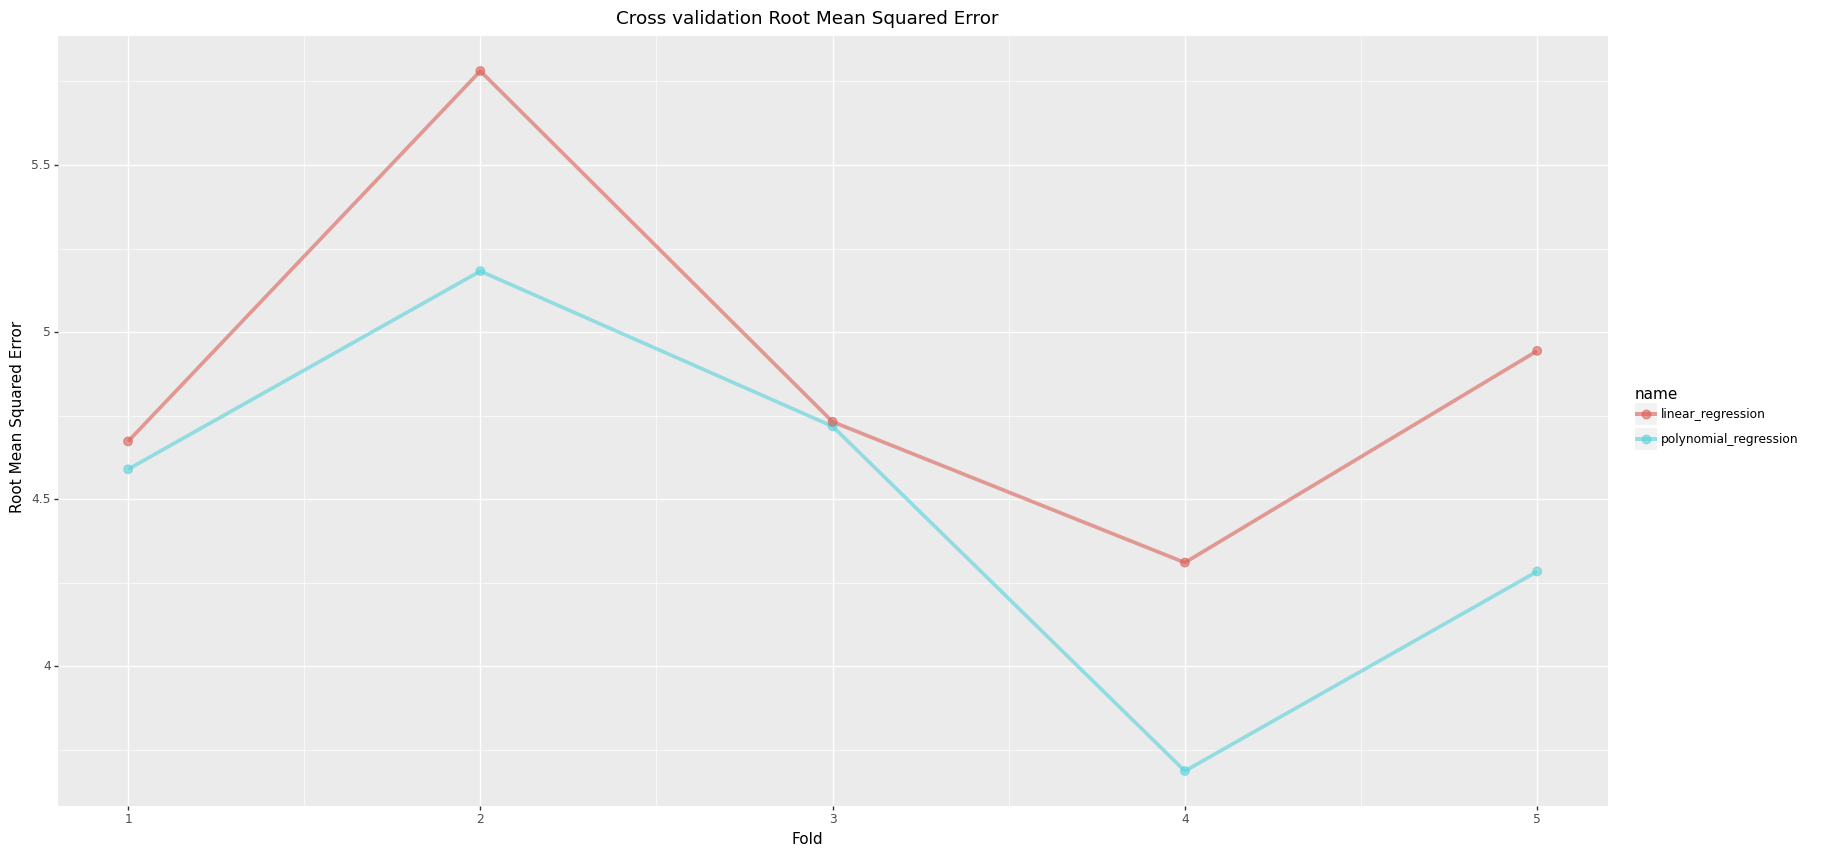

<ggplot: (8788658972132)>

In [146]:
(ggplot(cv_results_df) +
    aes(x="fold", y="rmse", color="name") +
    geom_line(size=1.5, alpha=0.6) +
    geom_point(size=3, alpha=0.6) +
    ggtitle("Cross validation Root Mean Squared Error") +
    theme(figure_size=(20, 10)) +
    xlab("Fold") +
    ylab("Root Mean Squared Error")
)


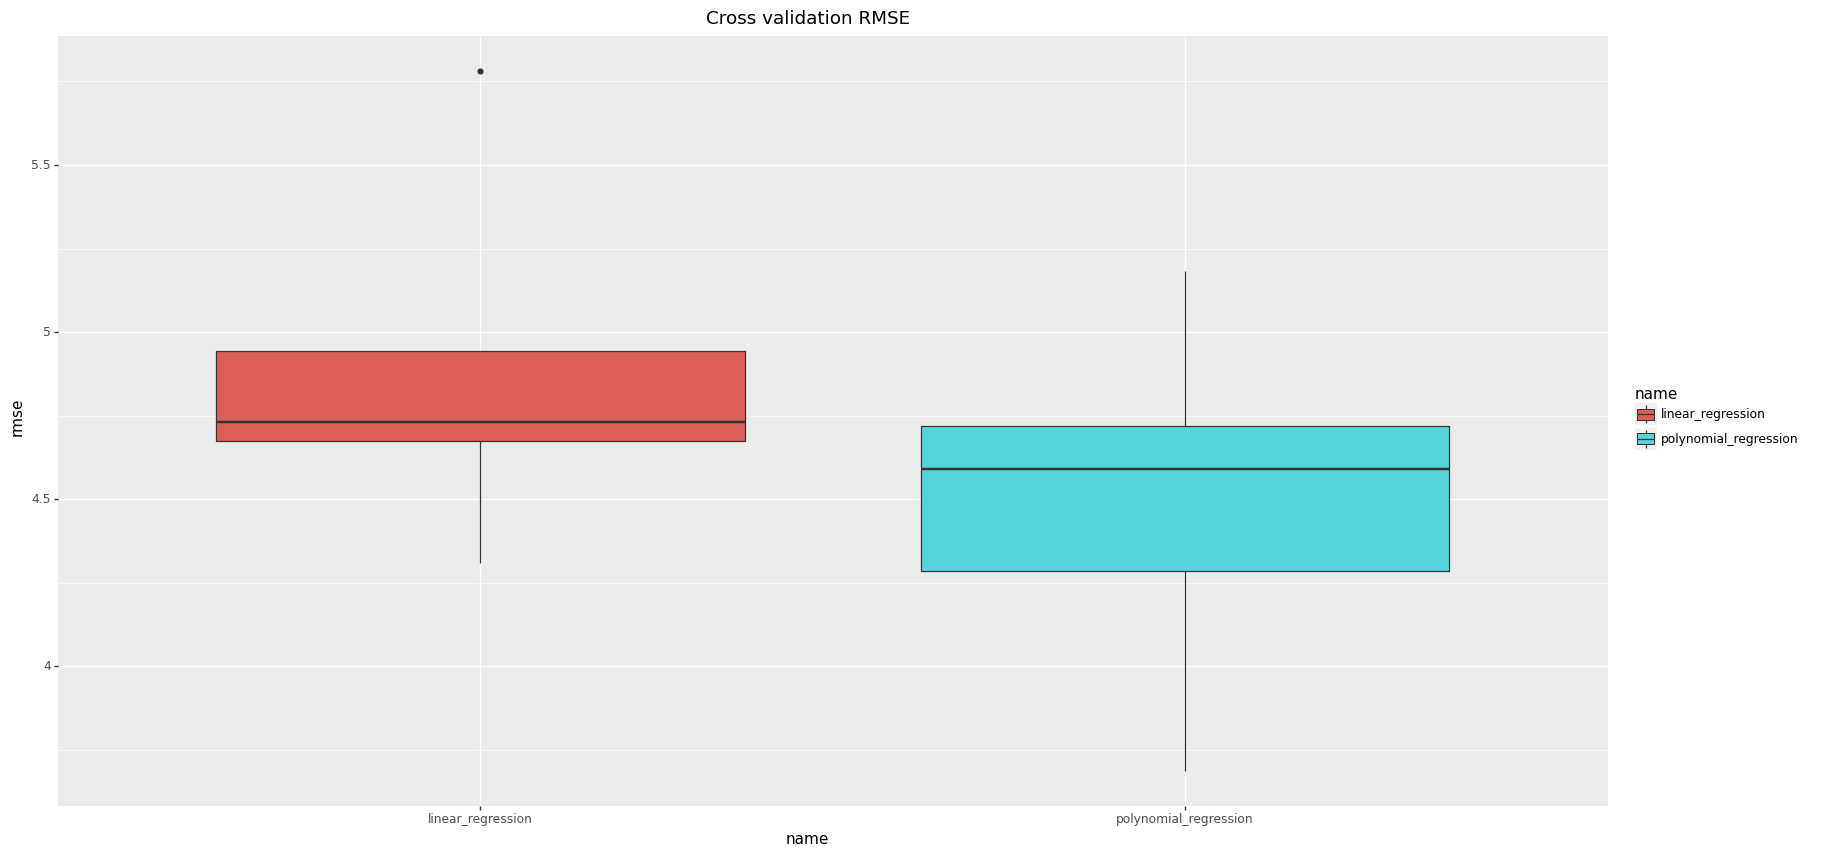

<ggplot: (8788658440646)>

In [147]:
(ggplot(cv_results_df) +
    aes(y="rmse", x="name", fill="name") +
    geom_boxplot() +
    ggtitle("Cross validation RMSE") +
    theme(figure_size=(20, 10))
)


### Train set fitted models on Engine Displacement

In [148]:
predictions_df = pd.concat(
    [X_train.assign(y=model.predict(X_train), model=name) for name, model in models]
)
show(predictions_df)

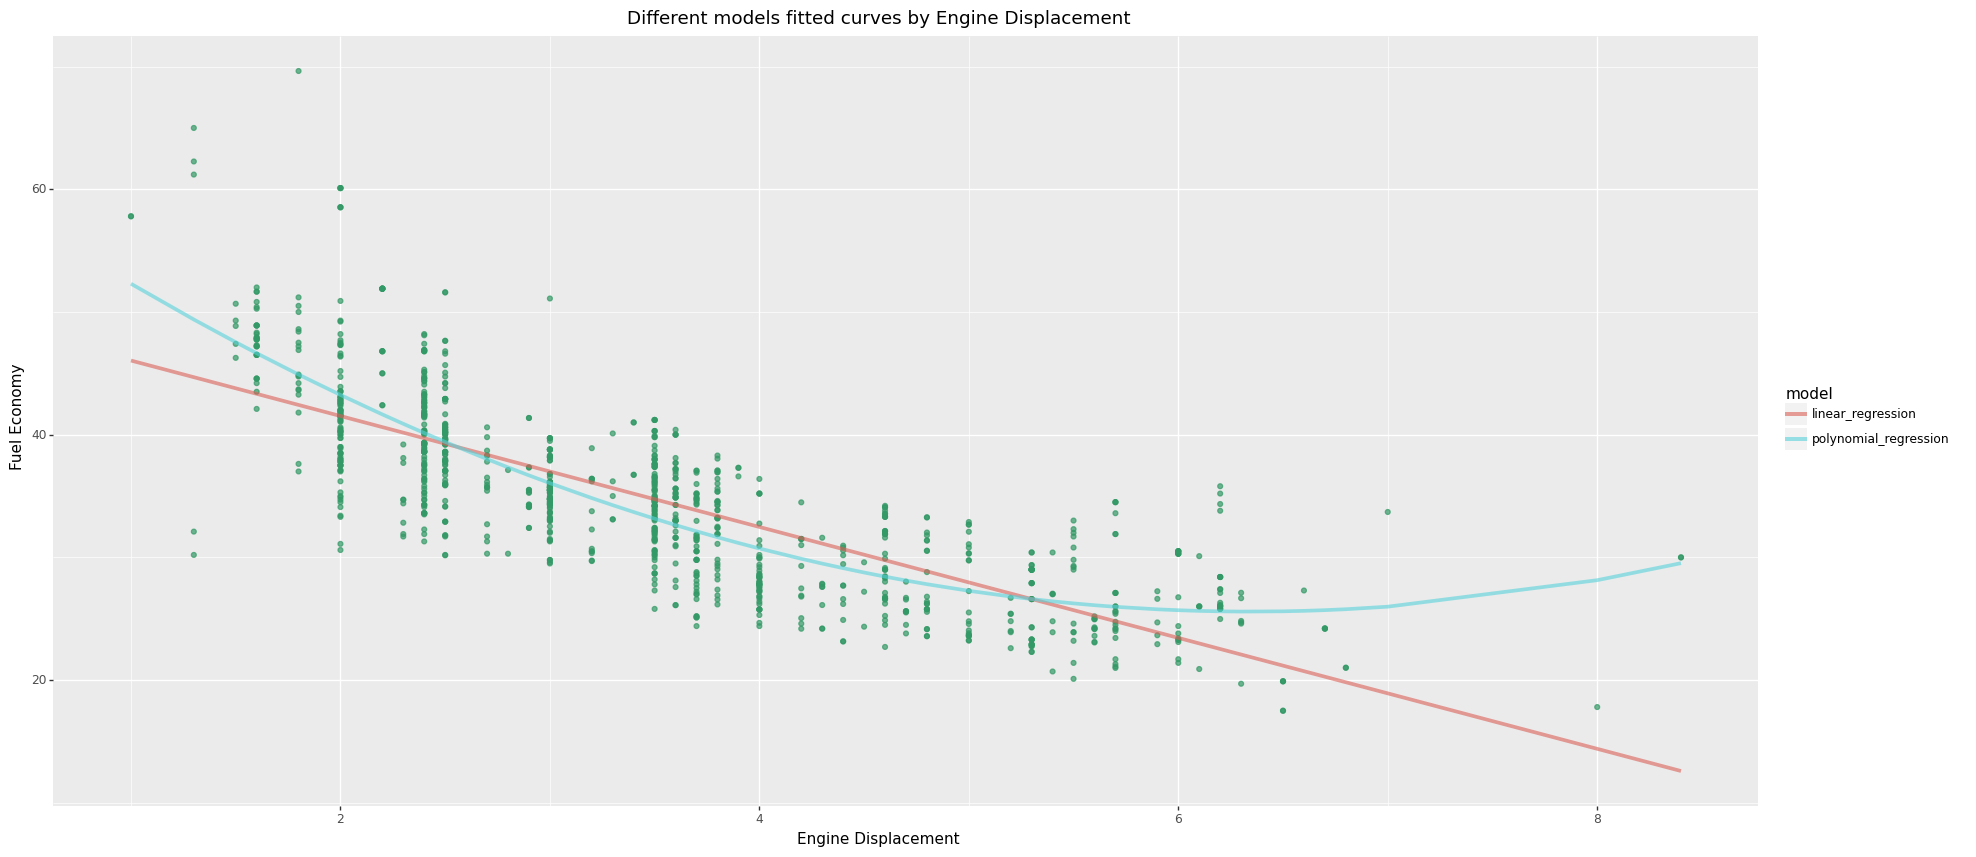

<ggplot: (8788658440475)>

In [149]:

(ggplot(X_train.assign(y=y_train)) + aes(x="eng_displ", y="y") +
    geom_point(color="#339966", alpha=0.7, size=1.5) +
    geom_line(
        aes(x="eng_displ", color="model"),
        data=predictions_df,
        size=1.5,
        alpha=0.6,
    ) +
    theme(figure_size=(22, 10)) +
    xlab("Engine Displacement") +
    ylab("Fuel Economy") +
    ggtitle("Different models fitted curves by Engine Displacement") 
    
)